# OpFlow codomain 1D experiment
### Pipeline  : 
``data preparation`` : specify the matern kernel for ``x`` and ``z`` (u and a in the paper)

``noise injection`` : select the GP noise level

``model`` : codomain model, checkboard mask is not needed

``training and fine-tuning`` : training with the penalty, select a smaller learning rate for fine-tuning without penalty

``statistical validation`` : mean and autocovariance function, super-resolution

``Regression``: get the MAP first, then use Functional Stochastic Gradient Langevin Dynamic. 

``paper plot`` : make plots for the paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
import timeit

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## dataset parameters and preparation

In [3]:
ntrain = 30000
ndim = 128
batch_size = 512

nchannel = 2

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.2
nu_z = 1.5

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm
def GaussianProcess_1C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel=1):
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    #y_samples = gpr_model.sample_y(X, n_samples)
    
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim, n_samples, nchannel]).shape)        
    
    if return_kernel:
        return torch.tensor(y_samples), kernel(X)
    else:
        return torch.tensor(y_samples)

Starting up. Generating GRF samples
torch.Size([30000, 128, 2])


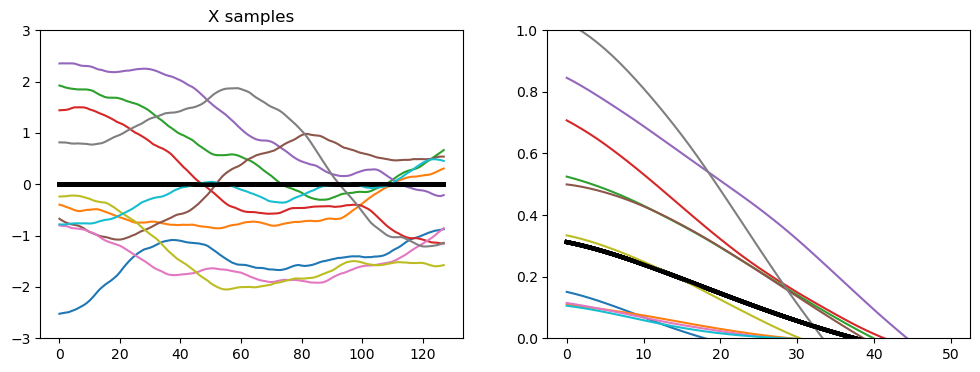

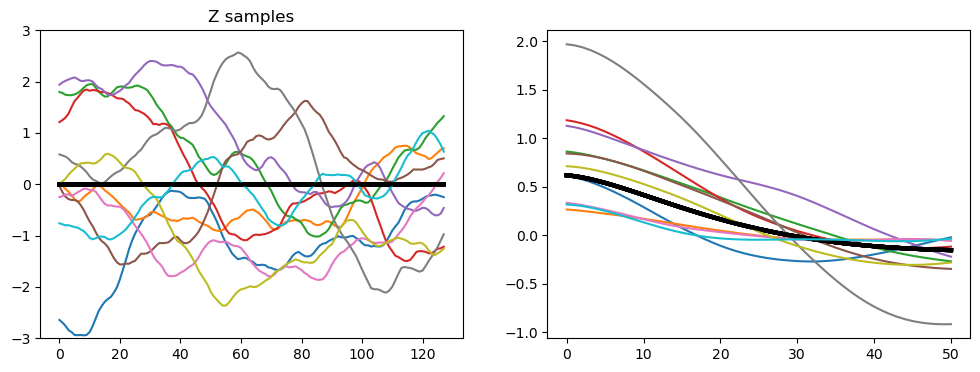

Finished sampling GRFs


In [45]:
print("Starting up. Generating GRF samples")

np.random.seed(10)
# nu = 0.5, the smaller, the less smooth (more rough) the approximated function is
x_train = GaussianProcess_1C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0, 2])
fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=(0,2))
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,:,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()

# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(ndim, length_scale_z, nu_z, ntrain*2, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0, 2])
#z_train = torch.randn(z_train.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
z_mean_true = z_train.mean(dim=(0,2))
z_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(z_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
# rename as z_loader
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True)

for i in range(10):
    #x = grf.sample(1)[0,:,0]
    z = z_train[i,:,0]
    ax[0].plot(z)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(z_mean_true, c='k', lw=3)
    ax[1].plot(z_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(z, nlag=50))
    #ax[1].set_ylim([0.0, 1.0])
    ax[0].set_title("Z samples")
plt.show()
print("Finished sampling GRFs")

### OpFlow model setup

In [6]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, n=x.size(-1))
        x = torch.fft.irfft(out_ft)
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv1d(int(in_channel), int(out_channel), 1)

    def forward(self,x):
        
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [7]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        #self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = pointwise_op(self.width, self.width) #
        
        self.w1 = pointwise_op(self.width, self.width) #
        
        self.w2 = pointwise_op(self.width, self.width) #
        
        self.w3 = pointwise_op(self.width, self.width) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=2)
        
        x = self.fc0(x)
        x = F.gelu(x)
               
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [8]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
            std = input.std(dim=(0,1)).unsqueeze(0).unsqueeze(1)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, modes, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.modes = modes
        self.width = width
        self.coupling = FNO1d(modes=self.modes, width=self.width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        #
        x = z
        x, log_actnorm = self.actnorm(x)
        
        """
        n_rep = x.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=x.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:x.shape[1]]
        mask_b = torch.logical_not(mask_a)
        # define the dimension
        x1 = x * mask_a[None,:,None] # x1 has the same shape of z, but for False in mask_a, values are replaced with 0
        x2 = x * mask_b[None,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
        """
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,0:1]
        x2 = x[:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
    
        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,0:1]
        z2 = z[:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], 2]).shape)
        log_scale = scale_shift[:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [10]:
class OpFlow(nn.Module):
    def __init__(self, modes, width, blocks, base_dist, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]

        self.bijectors = nn.ModuleList([
            AffineCoupling(modes=modes, width=width) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [12]:
lr = 5*1e-5
epochs = 600
reg_fac = 1

n_train_tot = int(ntrain/batch_size)
modes = ndim // 4
width = 64
#width = 128


blocks = 10
base_mu = torch.zeros(ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

## Validation

In [13]:
# load trained model
model = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)

# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = "paper_saved_models/GP2GP_FNO_codomain_prior/1D_codomain_649_prior.pt"
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [18]:
G = model

### Plot the contribution of the log_det from each block and final log_log
forward process, account the contribution of each block and 

In [14]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
nlag_eva = int(ndim//2)

x_pos = np.linspace(0, 1, ndim)
x_pos_acovf = x_pos[:nlag_eva]

nsample_eva = 5000

x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=nlag_eva-1)) for i in range(ntrain)]).mean(dim=0)

In [23]:
folder = "GP2GP_FNO_codomain_prior"
if not os.path.exists(f"paper_pdf/{folder}"):
    os.makedirs(f"paper_pdf/{folder}")

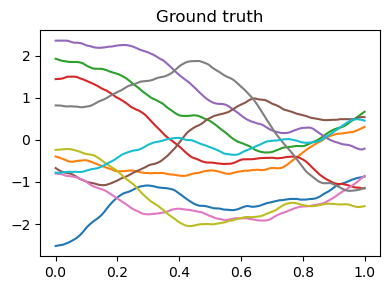

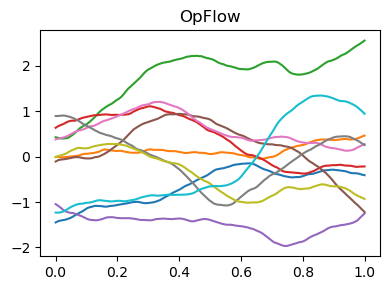

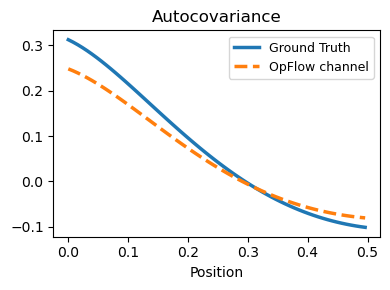

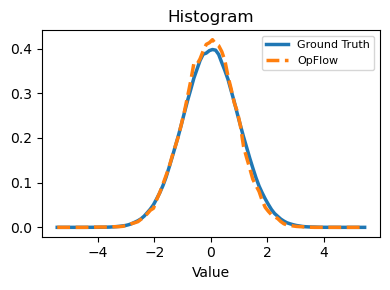

In [15]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
    Z = torch.cat([base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1)], axis=-1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    X_ground_truth = x_train[:10]

    #Z_alt = base_dist.rsample(sample_shape=(1000,))[:,:,None]
    Z_alt = torch.cat([base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1)], axis=-1)    

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)  
    
    x_hist_channel1, bin_edges_alt = X_alt[:,:,0].histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt[:,:,1].histogram(range=[-5.5,5.5], density=True)  
    
    # plot first ground truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
    plt.title('Ground truth')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,0]
        ax.plot(x_pos, x1)
    plt.title('OpFlow')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")

    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,1]
        ax.plot(x_pos, x1)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")
        
    """

    #x_mean_channel1 = X_alt[:,:,0].mean(dim=0)
    #x_mean_channel2 = X_alt[:,:,1].mean(dim=0)
    x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)
    x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow channel')
    #ax.plot(x_pos_acovf, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel')
    
    ax.set_xlabel('Position')
    ax.set_title('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')
    ax.set_xlabel('Value')
    ax.set_title('Histogram')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_hist.pdf")

## Regression

In [16]:
from sklearn.gaussian_process.kernels import WhiteKernel

In [19]:
for param in G.parameters():
    param.requires_grad = False

## $\log p_{\theta}(a_{\phi} |\widehat{u_{obs}}) = \log p_{\theta}(u_{\phi} |\widehat{u_{obs}})$ due to the fact under the learnt prior, we have $\mathcal{G}_{\theta}(a_{\phi}) = u_{\phi}$ and $a_{\phi} = \mathcal{G}^{-1}_{\theta}(u_{\phi})$

## Get the MAP for A

In [53]:
ndim = 128
lr = 1e-3 
epochs = 6000
noise_level = 0.01

pos_mask = torch.zeros(ndim)

pos_idx = np.random.choice(ndim, 6, replace=False)
#pos_idx = np.array([ 83, 112,  93,   4,  49,  15]) #used for the paper

pos_mask[pos_idx] = 1
#pos_mask[::int(ndim/8)] = 1
#pos_mask[-1] = 1 # this make the problem easier

pos_mask = (pos_mask==1)

u_obs_full = x_train[20:21,:,  :]
u_obs_part = u_obs_full[:,pos_mask,:].to(device)
u_obs_full = u_obs_full.squeeze()

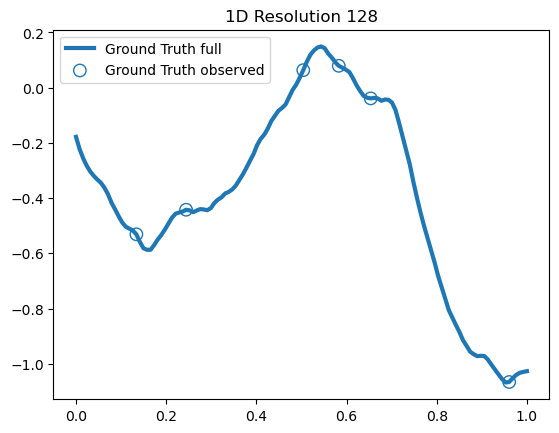

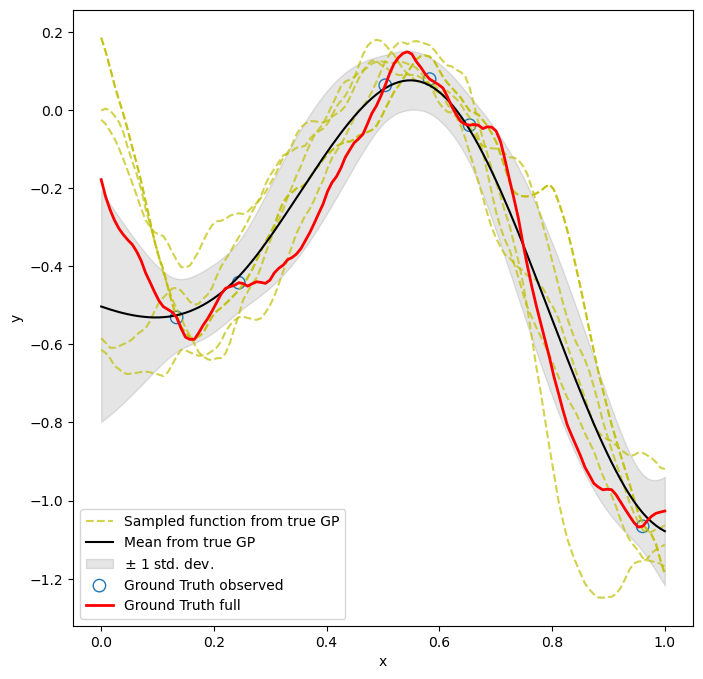

In [54]:
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=3, c='#1f77b4')
plt.scatter(x_range[pos_mask], u_obs_full[pos_mask,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.title('1D Resolution 128', fontsize=12)
plt.legend()

## Ground Truth GP
# u shouldn't add the white kernel ( do that only in estimation noisy level, build a second GP whith alpha)
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x) 

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part[:,:,0].squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 8))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(x_range[pos_mask], u_obs_full[pos_mask,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=2, c='r')
ax.legend()

## Get the MAP 

In [66]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,ndim, 2))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inverse(self.a_target)
        
    def logp(self):
        u = self.target_u()
        a, log_pa, log_det = self.G(u)
        return log_pa+log_det

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:,pos_mask,:])**2)/noise_level
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_u.u_target[:,pos_mask,:])**2)/noise_level
        loss2 = reg_opflow_a.logp()
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses


In [67]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [68]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:-724.1300659179688
epcoh:1, loss:-726.6363525390625
epcoh:2, loss:-729.1642456054688
epcoh:3, loss:-731.6322021484375
epcoh:4, loss:-734.0830078125
epcoh:5, loss:-736.4669189453125
epcoh:6, loss:-738.8489990234375
epcoh:7, loss:-741.2008056640625
epcoh:8, loss:-743.510498046875
epcoh:9, loss:-745.8015747070312
epcoh:10, loss:-748.0726318359375
epcoh:11, loss:-750.3092041015625
epcoh:12, loss:-752.5211181640625
epcoh:13, loss:-754.7109375
epcoh:14, loss:-756.8697509765625
epcoh:15, loss:-759.0031127929688
epcoh:16, loss:-761.114501953125
epcoh:17, loss:-763.196533203125
epcoh:18, loss:-765.2496337890625
epcoh:19, loss:-767.2802734375
epcoh:20, loss:-769.285400390625
epcoh:21, loss:-771.2623901367188
epcoh:22, loss:-773.214111328125
epcoh:23, loss:-775.1404418945312
epcoh:24, loss:-777.0409545898438
epcoh:25, loss:-778.9163208007812
epcoh:26, loss:-780.7667236328125
epcoh:27, loss:-782.5921630859375
epcoh:28, loss:-784.3931274414062
epcoh:29, loss:-786.1694946289062
epcoh:3

epcoh:241, loss:-934.6011962890625
epcoh:242, loss:-934.9069213867188
epcoh:243, loss:-935.2109985351562
epcoh:244, loss:-935.513671875
epcoh:245, loss:-935.8148803710938
epcoh:246, loss:-936.1146850585938
epcoh:247, loss:-936.4130859375
epcoh:248, loss:-936.7096557617188
epcoh:249, loss:-937.0049438476562
epcoh:250, loss:-937.298828125
epcoh:251, loss:-937.591552734375
epcoh:252, loss:-937.8825073242188
epcoh:253, loss:-938.1719360351562
epcoh:254, loss:-938.460205078125
epcoh:255, loss:-938.7471313476562
epcoh:256, loss:-939.0325317382812
epcoh:257, loss:-939.3163452148438
epcoh:258, loss:-939.59912109375
epcoh:259, loss:-939.8803100585938
epcoh:260, loss:-940.16015625
epcoh:261, loss:-940.4387817382812
epcoh:262, loss:-940.7157592773438
epcoh:263, loss:-940.9917602539062
epcoh:264, loss:-941.2664794921875
epcoh:265, loss:-941.53955078125
epcoh:266, loss:-941.8114013671875
epcoh:267, loss:-942.0821533203125
epcoh:268, loss:-942.3511352539062
epcoh:269, loss:-942.6194458007812
epcoh:2

epcoh:479, loss:-978.5502319335938
epcoh:480, loss:-978.6544799804688
epcoh:481, loss:-978.758056640625
epcoh:482, loss:-978.861572265625
epcoh:483, loss:-978.9644775390625
epcoh:484, loss:-979.06689453125
epcoh:485, loss:-979.1690673828125
epcoh:486, loss:-979.270751953125
epcoh:487, loss:-979.3720092773438
epcoh:488, loss:-979.473388671875
epcoh:489, loss:-979.5739135742188
epcoh:490, loss:-979.674072265625
epcoh:491, loss:-979.7736206054688
epcoh:492, loss:-979.8728637695312
epcoh:493, loss:-979.971923828125
epcoh:494, loss:-980.0703735351562
epcoh:495, loss:-980.16845703125
epcoh:496, loss:-980.2661743164062
epcoh:497, loss:-980.3634643554688
epcoh:498, loss:-980.4603881835938
epcoh:499, loss:-980.556884765625
epcoh:500, loss:-980.6533203125
epcoh:501, loss:-980.7496948242188
epcoh:502, loss:-980.8450317382812
epcoh:503, loss:-980.9404296875
epcoh:504, loss:-981.0350341796875
epcoh:505, loss:-981.1293334960938
epcoh:506, loss:-981.223388671875
epcoh:507, loss:-981.3168334960938
epc

epcoh:717, loss:-995.3024291992188
epcoh:718, loss:-995.3505859375
epcoh:719, loss:-995.398193359375
epcoh:720, loss:-995.4454956054688
epcoh:721, loss:-995.49267578125
epcoh:722, loss:-995.539794921875
epcoh:723, loss:-995.5867919921875
epcoh:724, loss:-995.6339111328125
epcoh:725, loss:-995.6810302734375
epcoh:726, loss:-995.7278442382812
epcoh:727, loss:-995.7744750976562
epcoh:728, loss:-995.8209838867188
epcoh:729, loss:-995.8670654296875
epcoh:730, loss:-995.9130249023438
epcoh:731, loss:-995.9590454101562
epcoh:732, loss:-996.0047607421875
epcoh:733, loss:-996.0507202148438
epcoh:734, loss:-996.0968627929688
epcoh:735, loss:-996.14306640625
epcoh:736, loss:-996.1890869140625
epcoh:737, loss:-996.2350463867188
epcoh:738, loss:-996.280517578125
epcoh:739, loss:-996.3256225585938
epcoh:740, loss:-996.37060546875
epcoh:741, loss:-996.41552734375
epcoh:742, loss:-996.4605712890625
epcoh:743, loss:-996.5059814453125
epcoh:744, loss:-996.5509643554688
epcoh:745, loss:-996.5955810546875

epcoh:952, loss:-1003.9922485351562
epcoh:953, loss:-1004.0206909179688
epcoh:954, loss:-1004.0491943359375
epcoh:955, loss:-1004.0774536132812
epcoh:956, loss:-1004.10595703125
epcoh:957, loss:-1004.1343994140625
epcoh:958, loss:-1004.1629638671875
epcoh:959, loss:-1004.1912841796875
epcoh:960, loss:-1004.2196044921875
epcoh:961, loss:-1004.2477416992188
epcoh:962, loss:-1004.2758178710938
epcoh:963, loss:-1004.3038940429688
epcoh:964, loss:-1004.33203125
epcoh:965, loss:-1004.3600463867188
epcoh:966, loss:-1004.3878784179688
epcoh:967, loss:-1004.4157104492188
epcoh:968, loss:-1004.4432983398438
epcoh:969, loss:-1004.4711303710938
epcoh:970, loss:-1004.4989013671875
epcoh:971, loss:-1004.5263061523438
epcoh:972, loss:-1004.5535888671875
epcoh:973, loss:-1004.580810546875
epcoh:974, loss:-1004.6082153320312
epcoh:975, loss:-1004.6354370117188
epcoh:976, loss:-1004.6627807617188
epcoh:977, loss:-1004.6900024414062
epcoh:978, loss:-1004.7173461914062
epcoh:979, loss:-1004.74462890625
ep

epcoh:1178, loss:-1009.2406616210938
epcoh:1179, loss:-1009.2598266601562
epcoh:1180, loss:-1009.2785034179688
epcoh:1181, loss:-1009.2967529296875
epcoh:1182, loss:-1009.3148193359375
epcoh:1183, loss:-1009.3331909179688
epcoh:1184, loss:-1009.3512573242188
epcoh:1185, loss:-1009.3695068359375
epcoh:1186, loss:-1009.3875732421875
epcoh:1187, loss:-1009.4054565429688
epcoh:1188, loss:-1009.423583984375
epcoh:1189, loss:-1009.4420166015625
epcoh:1190, loss:-1009.4603271484375
epcoh:1191, loss:-1009.4788208007812
epcoh:1192, loss:-1009.4970703125
epcoh:1193, loss:-1009.5151977539062
epcoh:1194, loss:-1009.5330810546875
epcoh:1195, loss:-1009.5509643554688
epcoh:1196, loss:-1009.5686645507812
epcoh:1197, loss:-1009.5866088867188
epcoh:1198, loss:-1009.6044311523438
epcoh:1199, loss:-1009.6223754882812
epcoh:1200, loss:-1009.6403198242188
epcoh:1201, loss:-1009.658203125
epcoh:1202, loss:-1009.6760864257812
epcoh:1203, loss:-1009.6937255859375
epcoh:1204, loss:-1009.7110595703125
epcoh:120

epcoh:1403, loss:-1012.6097412109375
epcoh:1404, loss:-1012.62109375
epcoh:1405, loss:-1012.6326293945312
epcoh:1406, loss:-1012.6444702148438
epcoh:1407, loss:-1012.65673828125
epcoh:1408, loss:-1012.668701171875
epcoh:1409, loss:-1012.6806640625
epcoh:1410, loss:-1012.692138671875
epcoh:1411, loss:-1012.7037353515625
epcoh:1412, loss:-1012.715576171875
epcoh:1413, loss:-1012.7271728515625
epcoh:1414, loss:-1012.7388916015625
epcoh:1415, loss:-1012.7504272460938
epcoh:1416, loss:-1012.7620849609375
epcoh:1417, loss:-1012.773681640625
epcoh:1418, loss:-1012.7852172851562
epcoh:1419, loss:-1012.7968139648438
epcoh:1420, loss:-1012.8084106445312
epcoh:1421, loss:-1012.8199462890625
epcoh:1422, loss:-1012.83154296875
epcoh:1423, loss:-1012.8430786132812
epcoh:1424, loss:-1012.8543701171875
epcoh:1425, loss:-1012.8657836914062
epcoh:1426, loss:-1012.8768920898438
epcoh:1427, loss:-1012.8882446289062
epcoh:1428, loss:-1012.8994140625
epcoh:1429, loss:-1012.9105834960938
epcoh:1430, loss:-10

epcoh:1629, loss:-1014.7614135742188
epcoh:1630, loss:-1014.76904296875
epcoh:1631, loss:-1014.7765502929688
epcoh:1632, loss:-1014.783935546875
epcoh:1633, loss:-1014.7910766601562
epcoh:1634, loss:-1014.798095703125
epcoh:1635, loss:-1014.8052978515625
epcoh:1636, loss:-1014.8126220703125
epcoh:1637, loss:-1014.8196411132812
epcoh:1638, loss:-1014.8267822265625
epcoh:1639, loss:-1014.8338012695312
epcoh:1640, loss:-1014.840576171875
epcoh:1641, loss:-1014.8475341796875
epcoh:1642, loss:-1014.8544921875
epcoh:1643, loss:-1014.86181640625
epcoh:1644, loss:-1014.8690795898438
epcoh:1645, loss:-1014.876708984375
epcoh:1646, loss:-1014.8842163085938
epcoh:1647, loss:-1014.8915405273438
epcoh:1648, loss:-1014.8988647460938
epcoh:1649, loss:-1014.906494140625
epcoh:1650, loss:-1014.9147338867188
epcoh:1651, loss:-1014.9227294921875
epcoh:1652, loss:-1014.9302368164062
epcoh:1653, loss:-1014.937255859375
epcoh:1654, loss:-1014.9437866210938
epcoh:1655, loss:-1014.95068359375
epcoh:1656, loss

epcoh:1855, loss:-1016.1182250976562
epcoh:1856, loss:-1016.1231689453125
epcoh:1857, loss:-1016.1282958984375
epcoh:1858, loss:-1016.1331787109375
epcoh:1859, loss:-1016.1380004882812
epcoh:1860, loss:-1016.1426391601562
epcoh:1861, loss:-1016.1473388671875
epcoh:1862, loss:-1016.15185546875
epcoh:1863, loss:-1016.1566162109375
epcoh:1864, loss:-1016.1611938476562
epcoh:1865, loss:-1016.1656494140625
epcoh:1866, loss:-1016.1699829101562
epcoh:1867, loss:-1016.17431640625
epcoh:1868, loss:-1016.1785888671875
epcoh:1869, loss:-1016.1834106445312
epcoh:1870, loss:-1016.18798828125
epcoh:1871, loss:-1016.1926879882812
epcoh:1872, loss:-1016.1973876953125
epcoh:1873, loss:-1016.2020263671875
epcoh:1874, loss:-1016.2067260742188
epcoh:1875, loss:-1016.2113647460938
epcoh:1876, loss:-1016.2158813476562
epcoh:1877, loss:-1016.22021484375
epcoh:1878, loss:-1016.2245483398438
epcoh:1879, loss:-1016.22900390625
epcoh:1880, loss:-1016.2338256835938
epcoh:1881, loss:-1016.2388916015625
epcoh:1882,

epcoh:2080, loss:-1016.979736328125
epcoh:2081, loss:-1016.9823608398438
epcoh:2082, loss:-1016.9852294921875
epcoh:2083, loss:-1016.98779296875
epcoh:2084, loss:-1016.990478515625
epcoh:2085, loss:-1016.9934692382812
epcoh:2086, loss:-1016.996826171875
epcoh:2087, loss:-1017.0001831054688
epcoh:2088, loss:-1017.003173828125
epcoh:2089, loss:-1017.0064086914062
epcoh:2090, loss:-1017.0095825195312
epcoh:2091, loss:-1017.0125122070312
epcoh:2092, loss:-1017.015625
epcoh:2093, loss:-1017.0188598632812
epcoh:2094, loss:-1017.0217895507812
epcoh:2095, loss:-1017.02490234375
epcoh:2096, loss:-1017.0277709960938
epcoh:2097, loss:-1017.0305786132812
epcoh:2098, loss:-1017.0336303710938
epcoh:2099, loss:-1017.0367431640625
epcoh:2100, loss:-1017.03955078125
epcoh:2101, loss:-1017.0426025390625
epcoh:2102, loss:-1017.0454711914062
epcoh:2103, loss:-1017.0481567382812
epcoh:2104, loss:-1017.0509643554688
epcoh:2105, loss:-1017.0537109375
epcoh:2106, loss:-1017.056640625
epcoh:2107, loss:-1017.05

epcoh:2306, loss:-1017.5413208007812
epcoh:2307, loss:-1017.54345703125
epcoh:2308, loss:-1017.5450439453125
epcoh:2309, loss:-1017.5463256835938
epcoh:2310, loss:-1017.5478515625
epcoh:2311, loss:-1017.55029296875
epcoh:2312, loss:-1017.5535888671875
epcoh:2313, loss:-1017.556884765625
epcoh:2314, loss:-1017.5596313476562
epcoh:2315, loss:-1017.561767578125
epcoh:2316, loss:-1017.5635986328125
epcoh:2317, loss:-1017.5647583007812
epcoh:2318, loss:-1017.5657958984375
epcoh:2319, loss:-1017.5673828125
epcoh:2320, loss:-1017.5693359375
epcoh:2321, loss:-1017.5718383789062
epcoh:2322, loss:-1017.5744018554688
epcoh:2323, loss:-1017.5770263671875
epcoh:2324, loss:-1017.5792236328125
epcoh:2325, loss:-1017.5811767578125
epcoh:2326, loss:-1017.5831298828125
epcoh:2327, loss:-1017.585205078125
epcoh:2328, loss:-1017.5873413085938
epcoh:2329, loss:-1017.5894775390625
epcoh:2330, loss:-1017.5911254882812
epcoh:2331, loss:-1017.5924682617188
epcoh:2332, loss:-1017.5938110351562
epcoh:2333, loss:

epcoh:2531, loss:-1017.9235229492188
epcoh:2532, loss:-1017.924560546875
epcoh:2533, loss:-1017.92529296875
epcoh:2534, loss:-1017.9262084960938
epcoh:2535, loss:-1017.9276123046875
epcoh:2536, loss:-1017.9293823242188
epcoh:2537, loss:-1017.9314575195312
epcoh:2538, loss:-1017.9336547851562
epcoh:2539, loss:-1017.935302734375
epcoh:2540, loss:-1017.9360961914062
epcoh:2541, loss:-1017.9366455078125
epcoh:2542, loss:-1017.9375610351562
epcoh:2543, loss:-1017.9389038085938
epcoh:2544, loss:-1017.940185546875
epcoh:2545, loss:-1017.9412231445312
epcoh:2546, loss:-1017.9420776367188
epcoh:2547, loss:-1017.94287109375
epcoh:2548, loss:-1017.9440307617188
epcoh:2549, loss:-1017.9459838867188
epcoh:2550, loss:-1017.9484252929688
epcoh:2551, loss:-1017.9509887695312
epcoh:2552, loss:-1017.9528198242188
epcoh:2553, loss:-1017.95361328125
epcoh:2554, loss:-1017.9542846679688
epcoh:2555, loss:-1017.955322265625
epcoh:2556, loss:-1017.9569702148438
epcoh:2557, loss:-1017.9589233398438
epcoh:2558,

epcoh:2755, loss:-1018.1901245117188
epcoh:2756, loss:-1018.1903686523438
epcoh:2757, loss:-1018.1908569335938
epcoh:2758, loss:-1018.192138671875
epcoh:2759, loss:-1018.1941528320312
epcoh:2760, loss:-1018.1969604492188
epcoh:2761, loss:-1018.1994018554688
epcoh:2762, loss:-1018.2008056640625
epcoh:2763, loss:-1018.2015991210938
epcoh:2764, loss:-1018.202392578125
epcoh:2765, loss:-1018.20361328125
epcoh:2766, loss:-1018.2049560546875
epcoh:2767, loss:-1018.205810546875
epcoh:2768, loss:-1018.2064819335938
epcoh:2769, loss:-1018.2075805664062
epcoh:2770, loss:-1018.208984375
epcoh:2771, loss:-1018.2105712890625
epcoh:2772, loss:-1018.2119750976562
epcoh:2773, loss:-1018.2130126953125
epcoh:2774, loss:-1018.2135620117188
epcoh:2775, loss:-1018.2140502929688
epcoh:2776, loss:-1018.2145385742188
epcoh:2777, loss:-1018.2159423828125
epcoh:2778, loss:-1018.2175903320312
epcoh:2779, loss:-1018.2190551757812
epcoh:2780, loss:-1018.2202758789062
epcoh:2781, loss:-1018.2210083007812
epcoh:2782

epcoh:2980, loss:-1018.4003295898438
epcoh:2981, loss:-1018.4006958007812
epcoh:2982, loss:-1018.4009399414062
epcoh:2983, loss:-1018.4017944335938
epcoh:2984, loss:-1018.4022827148438
epcoh:2985, loss:-1018.4025268554688
epcoh:2986, loss:-1018.403076171875
epcoh:2987, loss:-1018.40380859375
epcoh:2988, loss:-1018.4046630859375
epcoh:2989, loss:-1018.4053344726562
epcoh:2990, loss:-1018.4061889648438
epcoh:2991, loss:-1018.4072265625
epcoh:2992, loss:-1018.4085693359375
epcoh:2993, loss:-1018.4097900390625
epcoh:2994, loss:-1018.410888671875
epcoh:2995, loss:-1018.412109375
epcoh:2996, loss:-1018.4134521484375
epcoh:2997, loss:-1018.4146118164062
epcoh:2998, loss:-1018.415283203125
epcoh:2999, loss:-1018.4158325195312
epcoh:3000, loss:-1018.4161987304688
epcoh:3001, loss:-1018.4168090820312
epcoh:3002, loss:-1018.4175415039062
epcoh:3003, loss:-1018.4179077148438
epcoh:3004, loss:-1018.4185180664062
epcoh:3005, loss:-1018.4190673828125
epcoh:3006, loss:-1018.4196166992188
epcoh:3007, l

epcoh:3206, loss:-1018.5687866210938
epcoh:3207, loss:-1018.5692749023438
epcoh:3208, loss:-1018.56982421875
epcoh:3209, loss:-1018.570556640625
epcoh:3210, loss:-1018.5715942382812
epcoh:3211, loss:-1018.5724487304688
epcoh:3212, loss:-1018.5731201171875
epcoh:3213, loss:-1018.5734252929688
epcoh:3214, loss:-1018.573974609375
epcoh:3215, loss:-1018.5746459960938
epcoh:3216, loss:-1018.5753784179688
epcoh:3217, loss:-1018.5763549804688
epcoh:3218, loss:-1018.576904296875
epcoh:3219, loss:-1018.5774536132812
epcoh:3220, loss:-1018.5780639648438
epcoh:3221, loss:-1018.5786743164062
epcoh:3222, loss:-1018.5794677734375
epcoh:3223, loss:-1018.5802001953125
epcoh:3224, loss:-1018.5807495117188
epcoh:3225, loss:-1018.5809936523438
epcoh:3226, loss:-1018.5812377929688
epcoh:3227, loss:-1018.5816650390625
epcoh:3228, loss:-1018.5819091796875
epcoh:3229, loss:-1018.58203125
epcoh:3230, loss:-1018.5820922851562
epcoh:3231, loss:-1018.5819091796875
epcoh:3232, loss:-1018.5827026367188
epcoh:3233,

epcoh:3432, loss:-1018.7057495117188
epcoh:3433, loss:-1018.706787109375
epcoh:3434, loss:-1018.7081909179688
epcoh:3435, loss:-1018.71044921875
epcoh:3436, loss:-1018.7123413085938
epcoh:3437, loss:-1018.713623046875
epcoh:3438, loss:-1018.7139892578125
epcoh:3439, loss:-1018.7145385742188
epcoh:3440, loss:-1018.7147827148438
epcoh:3441, loss:-1018.7149047851562
epcoh:3442, loss:-1018.71533203125
epcoh:3443, loss:-1018.7164306640625
epcoh:3444, loss:-1018.7174072265625
epcoh:3445, loss:-1018.7182006835938
epcoh:3446, loss:-1018.7191162109375
epcoh:3447, loss:-1018.7200317382812
epcoh:3448, loss:-1018.7205810546875
epcoh:3449, loss:-1018.7208251953125
epcoh:3450, loss:-1018.7210083007812
epcoh:3451, loss:-1018.7216186523438
epcoh:3452, loss:-1018.7221069335938
epcoh:3453, loss:-1018.7222900390625
epcoh:3454, loss:-1018.7225341796875
epcoh:3455, loss:-1018.7227172851562
epcoh:3456, loss:-1018.7232055664062
epcoh:3457, loss:-1018.7237548828125
epcoh:3458, loss:-1018.7247924804688
epcoh:3

epcoh:3657, loss:-1018.833984375
epcoh:3658, loss:-1018.8350219726562
epcoh:3659, loss:-1018.8359375
epcoh:3660, loss:-1018.8368530273438
epcoh:3661, loss:-1018.8373413085938
epcoh:3662, loss:-1018.83740234375
epcoh:3663, loss:-1018.8372192382812
epcoh:3664, loss:-1018.83740234375
epcoh:3665, loss:-1018.8380126953125
epcoh:3666, loss:-1018.8388061523438
epcoh:3667, loss:-1018.8399658203125
epcoh:3668, loss:-1018.8406982421875
epcoh:3669, loss:-1018.8406982421875
epcoh:3670, loss:-1018.8406982421875
epcoh:3671, loss:-1018.8403930664062
epcoh:3672, loss:-1018.8404541015625
epcoh:3673, loss:-1018.8416137695312
epcoh:3674, loss:-1018.8432006835938
epcoh:3675, loss:-1018.8447875976562
epcoh:3676, loss:-1018.845947265625
epcoh:3677, loss:-1018.8460083007812
epcoh:3678, loss:-1018.84521484375
epcoh:3679, loss:-1018.84521484375
epcoh:3680, loss:-1018.8462524414062
epcoh:3681, loss:-1018.847900390625
epcoh:3682, loss:-1018.8492431640625
epcoh:3683, loss:-1018.849609375
epcoh:3684, loss:-1018.84

epcoh:3883, loss:-1018.9498291015625
epcoh:3884, loss:-1018.9503173828125
epcoh:3885, loss:-1018.9507446289062
epcoh:3886, loss:-1018.9512939453125
epcoh:3887, loss:-1018.9515991210938
epcoh:3888, loss:-1018.951904296875
epcoh:3889, loss:-1018.9523315429688
epcoh:3890, loss:-1018.952880859375
epcoh:3891, loss:-1018.9533081054688
epcoh:3892, loss:-1018.95361328125
epcoh:3893, loss:-1018.9536743164062
epcoh:3894, loss:-1018.953369140625
epcoh:3895, loss:-1018.953369140625
epcoh:3896, loss:-1018.9534912109375
epcoh:3897, loss:-1018.953369140625
epcoh:3898, loss:-1018.9533081054688
epcoh:3899, loss:-1018.9534301757812
epcoh:3900, loss:-1018.9539184570312
epcoh:3901, loss:-1018.9547119140625
epcoh:3902, loss:-1018.9556274414062
epcoh:3903, loss:-1018.9568481445312
epcoh:3904, loss:-1018.9580078125
epcoh:3905, loss:-1018.9588012695312
epcoh:3906, loss:-1018.9595336914062
epcoh:3907, loss:-1018.960205078125
epcoh:3908, loss:-1018.9608154296875
epcoh:3909, loss:-1018.9613647460938
epcoh:3910, 

epcoh:4108, loss:-1019.0537719726562
epcoh:4109, loss:-1019.0540771484375
epcoh:4110, loss:-1019.0546264648438
epcoh:4111, loss:-1019.0551147460938
epcoh:4112, loss:-1019.055419921875
epcoh:4113, loss:-1019.0556030273438
epcoh:4114, loss:-1019.0560302734375
epcoh:4115, loss:-1019.0565185546875
epcoh:4116, loss:-1019.0567626953125
epcoh:4117, loss:-1019.0571899414062
epcoh:4118, loss:-1019.057861328125
epcoh:4119, loss:-1019.0580444335938
epcoh:4120, loss:-1019.0582885742188
epcoh:4121, loss:-1019.0581665039062
epcoh:4122, loss:-1019.0584716796875
epcoh:4123, loss:-1019.0588989257812
epcoh:4124, loss:-1019.0592651367188
epcoh:4125, loss:-1019.0601806640625
epcoh:4126, loss:-1019.0612182617188
epcoh:4127, loss:-1019.0615844726562
epcoh:4128, loss:-1019.0615844726562
epcoh:4129, loss:-1019.0614624023438
epcoh:4130, loss:-1019.0616455078125
epcoh:4131, loss:-1019.0623779296875
epcoh:4132, loss:-1019.0628051757812
epcoh:4133, loss:-1019.0629272460938
epcoh:4134, loss:-1019.0628662109375
epc

epcoh:4333, loss:-1019.1470947265625
epcoh:4334, loss:-1019.1467895507812
epcoh:4335, loss:-1019.1461791992188
epcoh:4336, loss:-1019.1454467773438
epcoh:4337, loss:-1019.144775390625
epcoh:4338, loss:-1019.1445922851562
epcoh:4339, loss:-1019.144775390625
epcoh:4340, loss:-1019.1453857421875
epcoh:4341, loss:-1019.1466674804688
epcoh:4342, loss:-1019.148681640625
epcoh:4343, loss:-1019.1508178710938
epcoh:4344, loss:-1019.1530151367188
epcoh:4345, loss:-1019.1548461914062
epcoh:4346, loss:-1019.1556396484375
epcoh:4347, loss:-1019.1555786132812
epcoh:4348, loss:-1019.1556396484375
epcoh:4349, loss:-1019.1553955078125
epcoh:4350, loss:-1019.155517578125
epcoh:4351, loss:-1019.1559448242188
epcoh:4352, loss:-1019.1567993164062
epcoh:4353, loss:-1019.1583251953125
epcoh:4354, loss:-1019.1592407226562
epcoh:4355, loss:-1019.1593627929688
epcoh:4356, loss:-1019.1593017578125
epcoh:4357, loss:-1019.15966796875
epcoh:4358, loss:-1019.1600341796875
epcoh:4359, loss:-1019.16015625
epcoh:4360, 

epcoh:4558, loss:-1019.2388305664062
epcoh:4559, loss:-1019.2394409179688
epcoh:4560, loss:-1019.2394409179688
epcoh:4561, loss:-1019.2388305664062
epcoh:4562, loss:-1019.2382202148438
epcoh:4563, loss:-1019.2380981445312
epcoh:4564, loss:-1019.2385864257812
epcoh:4565, loss:-1019.2395629882812
epcoh:4566, loss:-1019.2406616210938
epcoh:4567, loss:-1019.2413940429688
epcoh:4568, loss:-1019.241943359375
epcoh:4569, loss:-1019.2427368164062
epcoh:4570, loss:-1019.2435913085938
epcoh:4571, loss:-1019.244384765625
epcoh:4572, loss:-1019.2449951171875
epcoh:4573, loss:-1019.2451171875
epcoh:4574, loss:-1019.244873046875
epcoh:4575, loss:-1019.244873046875
epcoh:4576, loss:-1019.2454833984375
epcoh:4577, loss:-1019.2462158203125
epcoh:4578, loss:-1019.2470092773438
epcoh:4579, loss:-1019.2479858398438
epcoh:4580, loss:-1019.248779296875
epcoh:4581, loss:-1019.2495727539062
epcoh:4582, loss:-1019.25
epcoh:4583, loss:-1019.2503051757812
epcoh:4584, loss:-1019.250732421875
epcoh:4585, loss:-101

epcoh:4784, loss:-1019.3248291015625
epcoh:4785, loss:-1019.3251953125
epcoh:4786, loss:-1019.3257446289062
epcoh:4787, loss:-1019.326416015625
epcoh:4788, loss:-1019.3268432617188
epcoh:4789, loss:-1019.3275756835938
epcoh:4790, loss:-1019.3286743164062
epcoh:4791, loss:-1019.3287963867188
epcoh:4792, loss:-1019.328369140625
epcoh:4793, loss:-1019.3281860351562
epcoh:4794, loss:-1019.3287963867188
epcoh:4795, loss:-1019.3294677734375
epcoh:4796, loss:-1019.3297729492188
epcoh:4797, loss:-1019.3300170898438
epcoh:4798, loss:-1019.33056640625
epcoh:4799, loss:-1019.3309936523438
epcoh:4800, loss:-1019.3310546875
epcoh:4801, loss:-1019.3309936523438
epcoh:4802, loss:-1019.3311767578125
epcoh:4803, loss:-1019.3316650390625
epcoh:4804, loss:-1019.3320922851562
epcoh:4805, loss:-1019.3323974609375
epcoh:4806, loss:-1019.3328857421875
epcoh:4807, loss:-1019.333740234375
epcoh:4808, loss:-1019.3343505859375
epcoh:4809, loss:-1019.3348388671875
epcoh:4810, loss:-1019.33544921875
epcoh:4811, lo

epcoh:5010, loss:-1019.4058227539062
epcoh:5011, loss:-1019.4063720703125
epcoh:5012, loss:-1019.406494140625
epcoh:5013, loss:-1019.4063720703125
epcoh:5014, loss:-1019.40673828125
epcoh:5015, loss:-1019.4072875976562
epcoh:5016, loss:-1019.4085083007812
epcoh:5017, loss:-1019.409423828125
epcoh:5018, loss:-1019.4096069335938
epcoh:5019, loss:-1019.4091186523438
epcoh:5020, loss:-1019.40869140625
epcoh:5021, loss:-1019.4085693359375
epcoh:5022, loss:-1019.4086303710938
epcoh:5023, loss:-1019.4088745117188
epcoh:5024, loss:-1019.4093627929688
epcoh:5025, loss:-1019.409423828125
epcoh:5026, loss:-1019.4097900390625
epcoh:5027, loss:-1019.409912109375
epcoh:5028, loss:-1019.4098510742188
epcoh:5029, loss:-1019.410400390625
epcoh:5030, loss:-1019.4110717773438
epcoh:5031, loss:-1019.4119873046875
epcoh:5032, loss:-1019.4130859375
epcoh:5033, loss:-1019.41455078125
epcoh:5034, loss:-1019.415771484375
epcoh:5035, loss:-1019.4163208007812
epcoh:5036, loss:-1019.4165649414062
epcoh:5037, loss

KeyboardInterrupt: 

## Validation of the MAP result

In [ ]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [69]:
u_opflow = reg_opflow_a.target_u().data.squeeze().cpu().detach()
u_opflow_old = u_opflow.clone() #save a copy
x_range = np.linspace(0,1,ndim)
X = x_range.reshape(-1, 1)

In [72]:
u_obs_part.shape

torch.Size([1, 6, 2])

In [84]:



## Ground Truth GP
#test_length_scale = 0.5
#test_nu = 1.5
#true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds=(1e-1, 10.0), nu=nu_x)  #+ WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
true_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)  #+ WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')

gpr_model_ground_truth = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

x_obs = x_range[pos_mask][:,np.newaxis]
y_obs = u_obs_part[:,:,0].squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model 

y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, 5)


## second channel
gpr_model_ground_truth_channel2 = GaussianProcessRegressor(kernel=true_kernel, alpha=noise_level)

y_obs_channel2 = u_obs_part[:,:,1].squeeze().detach().cpu().numpy()
gpr_model_ground_truth_channel2 = gpr_model_ground_truth_channel2.fit(x_obs, y_obs_channel2) #update the GP model 

y_mean_channel2, y_std_channel2 = gpr_model_ground_truth_channel2.predict(X, return_std=True)
y_samples_channel2 = gpr_model_ground_truth_channel2.sample_y(X, 5)

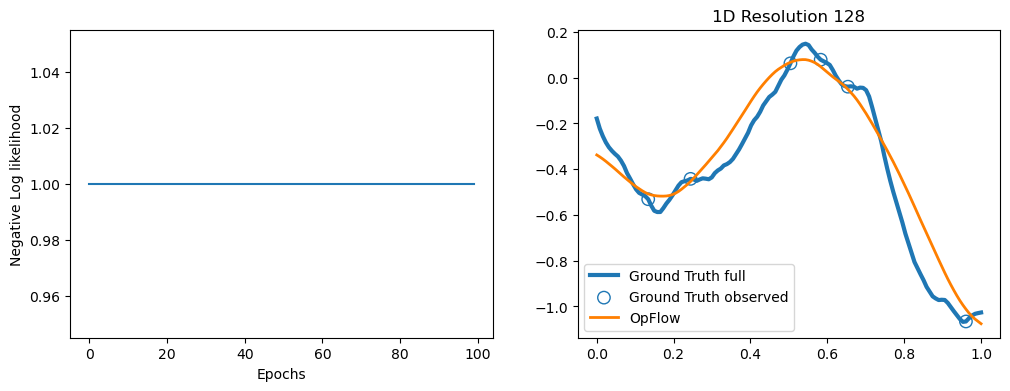

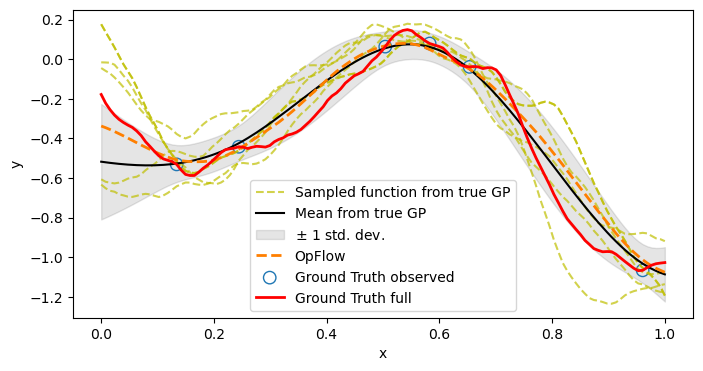

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.ones(100))
#axs[0].plot(losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Negative Log likelihood')

axs[1].plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=3, c='#1f77b4')
axs[1].scatter(x_range[pos_mask], u_obs_full[pos_mask,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
axs[1].plot(x_range, u_opflow[:,0], label='OpFlow', lw=2, c='#ff7f00')
axs[1].set_title('1D Resolution 128', fontsize=12)
axs[1].legend()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 4))
for idx, single_prior in enumerate(y_samples.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean - y_std,
    y_mean + y_std,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x_range, u_opflow[:,0], label='OpFlow', ls='--', lw=2, c='#ff7f00')
plt.scatter(x_range[pos_mask], u_obs_full[pos_mask,0], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,0], label='Ground Truth full', lw=2, c='r')
ax.legend()
#ax.set_ylim([-3, 3])
#plt.savefig(f"paper_pdf/{folder}_MAP_regressoin.pdf")

## also plot the second chanel

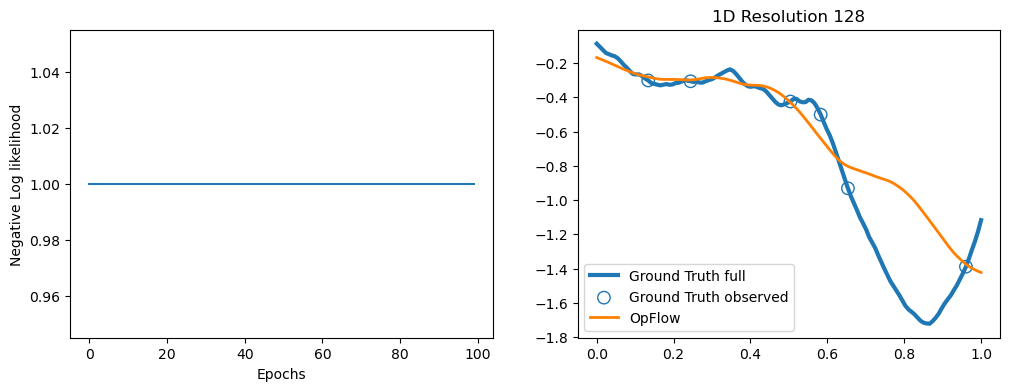

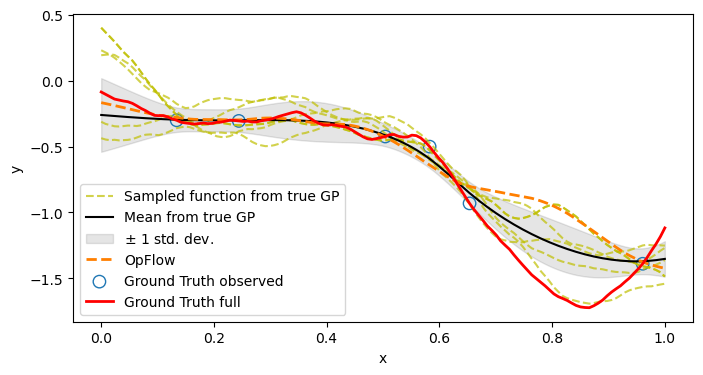

In [86]:
## second channel 
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.ones(100))
#axs[0].plot(losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Negative Log likelihood')

axs[1].plot(x_range, u_obs_full[:,1], label='Ground Truth full', lw=3, c='#1f77b4')
axs[1].scatter(x_range[pos_mask], u_obs_full[pos_mask,1], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
axs[1].plot(x_range, u_opflow[:,1], label='OpFlow', lw=2, c='#ff7f00')
axs[1].set_title('1D Resolution 128', fontsize=12)
axs[1].legend()

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8, 4))
for idx, single_prior in enumerate(y_samples_channel2.T):
    ax.plot(
        x_range,
        single_prior,
        linestyle="--",
        alpha=0.7,
        c = 'y'
    )
    if idx==4:
        ax.plot(
            x_range,
            single_prior,
            linestyle="--",
            alpha=0.7,
            c = 'y',
            label=f"Sampled function from true GP",
        )        
    

ax.plot(x_range, y_mean_channel2, color="black", label="Mean from true GP")
ax.fill_between(
    x_range,
    y_mean_channel2 - y_std_channel2,
    y_mean_channel2 + y_std_channel2,
    alpha=0.1,
    color="black",
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x_range, u_opflow[:,1], label='OpFlow', ls='--', lw=2, c='#ff7f00')
plt.scatter(x_range[pos_mask], u_obs_full[pos_mask,1], s=80,  facecolors='none', edgecolors='#1f77b4', label='Ground Truth observed')
plt.plot(x_range, u_obs_full[:,1], label='Ground Truth full', lw=2, c='r')
ax.legend()
#ax.set_ylim([-3, 3])
#plt.savefig(f"paper_pdf/{folder}_MAP_regressoin.pdf")

## also plot the second chanel

## SGLD sampling

In [87]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_SGLD

import sampling_SGLD.samplers


import sampling_SGLD.SGLD
reload(sampling_SGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_SGLD.samplers)
from sampling_SGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_1788678/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Regression on $\mathcal{A}$ Gaussian space

In [88]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [96]:
a_opflow_copy.shape

torch.Size([1, 128, 2])

In [89]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood
    u_from_a = G.inverse(a)
    loss1 = -0.5*torch.sum((u_obs_part - u_from_a[:,pos_mask,:])**2)/noise_level
    
    _, log_pa, log_det = G(u_from_a) 
    loss2 = log_pa + log_det
    
    loss = -(loss1 + loss2) 
    return loss

In [106]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1

max_itr = int(4e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-5,
                                     lr_final=4e-5,
                                     max_itr=max_itr,
                                     device=device,
                                     base_dist = base_dist,
                                     temperature = temperature,
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [1:22:55<00:00,  8.04it/s]


In [ ]:
## regression using GP on A 

In [107]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
u_samples_all = G.inverse(a_samples_all)

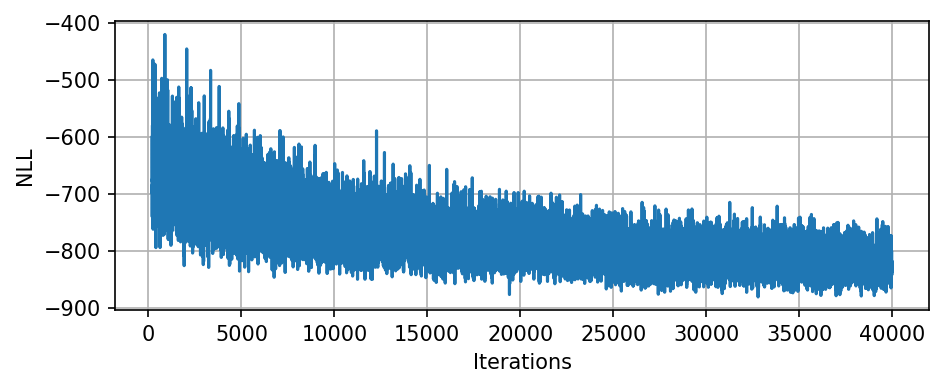

In [108]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

## Get target U

In [120]:
est_samples = u_samples_all.detach().cpu().numpy()

In [121]:
est_samples = est_samples[200:]

In [122]:
x = np.linspace(0, 1, ndim)
X = x.reshape(-1, 1)

In [112]:
est_samples.shape

(4000, 128, 2)

Text(0, 0.5, 'value')

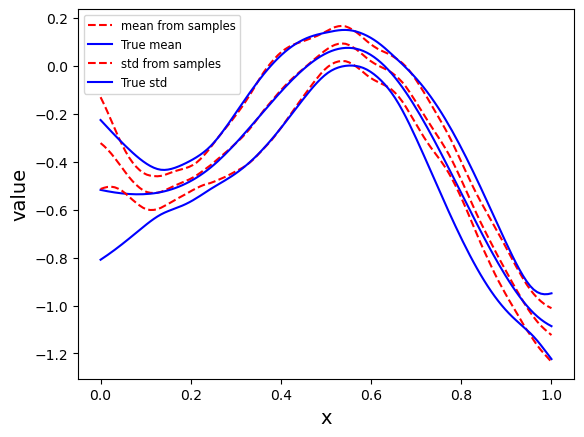

In [123]:
sample_std = np.std(est_samples[:,:,0], axis=0).squeeze()
sample_mean = np.mean(est_samples[:,:,0], axis=0).squeeze()

plt.plot(x, sample_mean, c='r', ls='--', label='mean from samples')
plt.plot(x, y_mean, c='b', label='True mean')
plt.plot(x, sample_mean-sample_std, c='r', ls='--', label='std from samples')
plt.plot(x, sample_mean+sample_std, c='r', ls='--')
plt.plot(x, y_mean-y_std,c='b', label='True std' )
plt.plot(x,y_mean+y_std, c='b')
plt.legend(fontsize='small')
plt.xlabel('x', fontsize=14)
plt.ylabel('value', fontsize=14)
#plt.savefig(f"paper_pdf/{folder}_SGLD_mean_std.pdf")

## Plot

In [126]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_samples = gpr_model_ground_truth.sample_y(X, len(est_samples)).T

opflow_std = np.std(est_samples, axis=0).squeeze()
opflow_mean = np.mean(est_samples, axis=0).squeeze()

sample_idx = np.random.choice(len(est_samples), 5, replace=False)

samples_opflow = est_samples[sample_idx].squeeze()
samples_ground_truth = y_samples[sample_idx].squeeze()

In [127]:
saved_folder = 'GP2GP_codomain_reg'
if not os.path.exists(f"Regression_results/{saved_folder}"):
    os.makedirs(f"Regression_results/{saved_folder}")

In [128]:
u_obs_full.shape

torch.Size([128, 2])

In [134]:
samples_opflow.shape

(5, 128, 2)

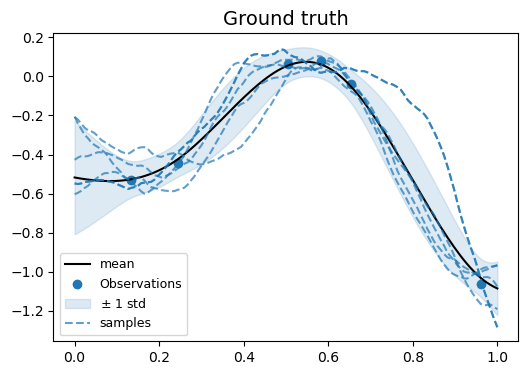

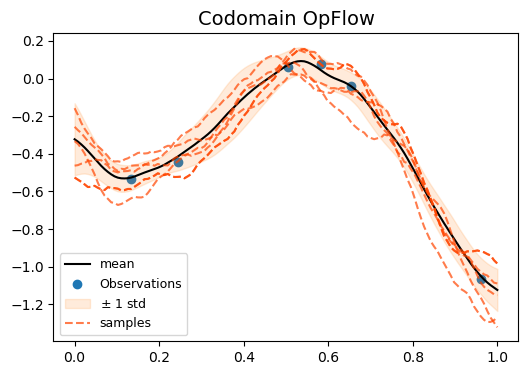

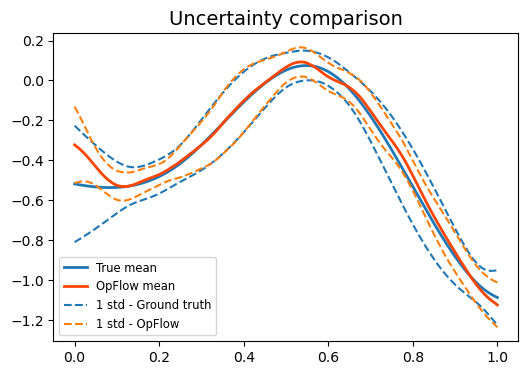

In [136]:
## Figure 1 (Ground Truth : mean + std + samples)
## Figure 2 (OpFlow : mean + std _samples)
## Figure 3 (Mean and Std comparision) 
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, y_mean, c='k', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask,0],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.15, color="#1f77b4", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_ground_truth):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#1f77b4', label=f"samples")

ax.set_title('Ground truth', fontsize=14)       
ax.legend(loc='lower left', fontsize=9)
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_gt.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_range, opflow_mean[:,0], c='black', label='mean')
ax.scatter(x_range[pos_mask], u_obs_full[pos_mask,0],edgecolors='#1f77b4', label="Observations")
ax.fill_between(x, (opflow_mean - opflow_std)[:,0], (opflow_mean + opflow_std)[:,0], alpha=0.15, color="#ff7f0e", label=r"$\pm$ 1 std")
for idx, single_prior in enumerate(samples_opflow[:,:,0]):
    ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500')
    if idx==0:
        ax.plot(x_range,single_prior,linestyle="--",alpha=0.7, c='#FF4500', label=f"samples")

ax.set_title('Codomain OpFlow', fontsize=14)
#ax.set_title('OpFlow - Regression on A, white noise', fontsize=14)
ax.legend(loc='lower left', fontsize=9)
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_opflow.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('Uncertainty comparison', fontsize=14)
ax.plot(x_range, y_mean, lw=2, c='#1f77b4', label='True mean')
ax.plot(x_range, opflow_mean[:,0], lw=2, c='#FF4500', label='OpFlow mean')
#ax.plot(x_range, u_opflow_copy.squeeze(), lw=2, c='k', label='OpFlow MAP' )
ax.plot(x, y_mean-y_std,ls='--',c='#1f77b4', label=r'1 std - Ground truth' )
ax.plot(x,y_mean+y_std,ls='--', c='#1f77b4')
#ax.plot(x, y_mean-opflow_std, c='#ff7f0e', ls='--', label=r'1 $\sigma$ - OpFlow')
#ax.plot(x, y_mean+opflow_std, c='#ff7f0e', ls='--')
ax.plot(x, (opflow_mean-opflow_std)[:,0], c='#ff7f0e', ls='--', label=r'1 std - OpFlow')
ax.plot(x, (opflow_mean+opflow_std)[:,0], c='#ff7f0e', ls='--')
ax.legend(fontsize='small')
plt.savefig(f"Regression_results/{saved_folder}/GP2GP_codomain_uncertainty.pdf")

### generate hdf5 file for saving the info

In [137]:
import h5py
f = h5py.File(f"Regression_results/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=pos_idx)
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()